# Tandon_Torch Final Project

####  Team Member
* Chuan Long
* Qingyi Ma
* Suyang Jiang

### 0. Some useful Links

* [final-project proposal](https://docs.google.com/a/nyu.edu/document/d/1-7z-mpCGSWKxE0MdWpkioPb0_NaM8gSmMzCj4mR3PpE/edit?usp=sharing)
* [kaggle-pipeline](https://www.zhihu.com/question/23987009)

### 1. Data Exploration
* 查看目标变量的分布。当分布不平衡时，根据评分标准和具体模型的使用不同，可能会严重影响性能。
* 对 Numerical Variable，可以用 Box Plot 来直观地查看它的分布。
* 对于坐标类数据，可以用 Scatter Plot 来查看它们的分布趋势和是否有离群点的存在。
* 对于分类问题，将数据根据 Label 的不同着不同的颜色绘制出来，这对 Feature 的构造很有帮助。绘制变量之间两两的分布和相关度图表。


In [24]:
# Import some useful modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from sklearn import ensemble
from sklearn import metrics
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier

In [51]:
file_path = '/Users/chuanlong/GitHub/Tandon_Torch/data/train.json'
df = pd.read_json(file_path);
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [52]:
df.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')

#### Feature Extracion

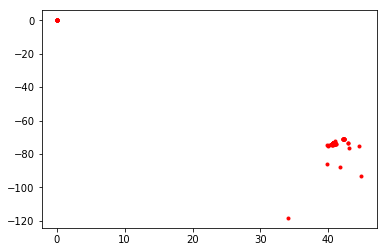

In [53]:
plt.plot(df.latitude, df.longitude, 'r.')
plt.show()

In [54]:
# Vectorize the attribute description(text) based on tfidf method
tfidf_vect = TfidfVectorizer()
tfidf_mat = tfidf_vect.fit_transform(df.description)
tfidf_mat

<49352x37823 sparse matrix of type '<class 'numpy.float64'>'
	with 3418096 stored elements in Compressed Sparse Row format>

In [55]:
transformer = TfidfTransformer()
tfidf_value = transformer.fit_transform(tfidf_mat)
tfidf_value

<49352x37823 sparse matrix of type '<class 'numpy.float64'>'
	with 3418096 stored elements in Compressed Sparse Row format>

In [56]:
transformer.idf_

array([  6.82314721,   4.42338569,  11.11360665, ...,  11.11360665,
         9.86084368,  10.70814154])

In [57]:
# Filter the building list that missing building id
outlier_filter_buildingid = (df.building_id != '0')
df = df[outlier_filter_buildingid]
df.building_id.value_counts
df.building_id.describe()

count                                41066
unique                                7584
top       96274288c84ddd7d5c5d8e425ee75027
freq                                   275
Name: building_id, dtype: object

In [58]:
df.price.describe()
# Filter the abnormal price
# Adjust the range based on the hist figure
outlier_filer_price = (500 < df.price) & (df.price < 8000)
df = df[outlier_filer_price]
df.price.describe()

count    39659.000000
mean      3414.301621
std       1280.831943
min        695.000000
25%       2500.000000
50%       3150.000000
75%       4000.000000
max       7999.000000
Name: price, dtype: float64

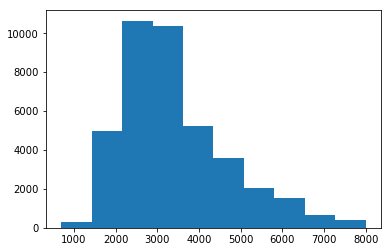

In [59]:
plt.hist(df.price)
plt.show()

In [60]:
# Filter the missing listing id
df = df[df.listing_id.isnull() == False]

In [61]:
df.longitude.describe()

count    39659.000000
mean       -73.957529
std          1.141362
min       -118.271000
25%        -73.992500
50%        -73.978900
75%        -73.956200
max          0.000000
Name: longitude, dtype: float64

In [62]:
df.latitude.describe()

count    39659.000000
mean        40.740631
std          0.616963
min          0.000000
25%         40.728000
50%         40.749400
75%         40.771600
max         44.603800
Name: latitude, dtype: float64

In [63]:
outlier_filter_longitude = (df.longitude > -74.2) & (df.longitude < -73.6)
df = df[outlier_filter_longitude]
outlier_filter_latitude = (df.latitude > 40.0) & (df.latitude < 41.0) 
df = df[outlier_filter_latitude]

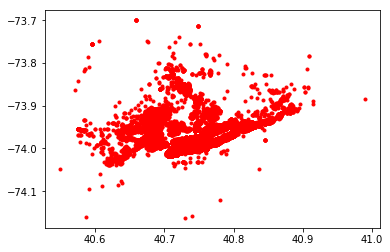

In [64]:
plt.plot(df.latitude, df.longitude, 'r.')
plt.show()

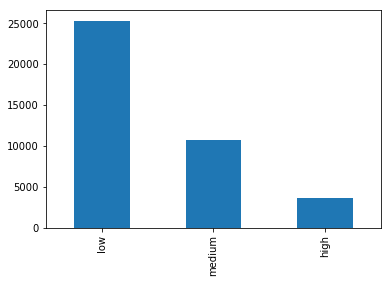

In [39]:
df.interest_level.value_counts().plot(kind = 'bar')
plt.show()

In [67]:
def transformCreatedTime(df, attribute):
    current_time = pd.to_datetime('2017-01-01')
    df[attribute] = df[attribute].map(lambda x : current_time - pd.to_datetime(x))\
                                 .map(lambda x : x / np.timedelta64(1, 's'))\
                                 .map(lambda x : float(x) / (60 * 60 * 24))
    return df[attribute]

In [68]:
df.created = transformCreatedTime(df, 'created')

In [46]:
df.created

10        190.670556
10000     202.486493
100004    258.856470
100007    257.901366
100014    256.816123
100016    248.861157
100020    262.748819
100026    255.891262
100044    256.765683
100051    257.891667
100052    253.751898
100055    255.832963
100058    266.840486
100062    263.889063
100063    268.908507
100065    262.779363
100066    258.898009
10007     207.805602
100071    248.719676
100075    250.895949
100076    253.764468
100079    254.772801
100081    249.875266
100083    254.904537
100084    271.826377
100085    253.792650
100087    255.886586
10009     197.853889
100098    258.905069
100099    269.730660
             ...    
99897     269.838264
99898     262.805625
99899     252.772477
99902     271.896285
99903     264.487662
99906     260.827593
99908     269.700301
9991      212.441458
99917     249.803310
99919     267.755590
99921     246.372581
99924     251.864375
99933     272.839340
99937     261.764201
99953     249.903981
99960     270.808657
99961     253

### Feature Engineering

In [47]:
# Format the dataset
columns = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'created', 'interest_level']
train_data = df[columns]

In [70]:
train_data.describe()

,bathrooms,bedrooms,latitude,longitude,price,created
count,39613.000000,39613.000000,39613.000000,39613.000000,39613.000000,39613.000000
mean,1.173327,1.512963,40.749470,-73.973182,3415.145861,229.570987
std,0.413439,1.085214,0.037945,0.030104,1280.756355,25.832311
min,0.000000,0.000000,40.549400,-74.162600,700.000000,185.095984
25%,1.000000,1.000000,40.728100,-73.992500,2500.000000,206.339398
50%,1.000000,1.000000,40.749400,-73.978900,3150.000000,229.249826
75%,1.000000,2.000000,40.771600,-73.956300,4000.000000,252.413877
max,10.000000,8.000000,40.989400,-73.700100,7999.000000,274.074525


In [71]:
# Load the testset
test_data = pd.read_json('/Users/chuanlong/GitHub/Tandon_Torch/data/train.json')
test_data = test_data[columns]
test_data['created'] = transformCreatedTime(test_data, 'created')

In [72]:
test_data.describe()

,bathrooms,bedrooms,latitude,longitude,price,created
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04,49352.000000
mean,1.21218,1.541640,40.741545,-73.955716,3.830174e+03,229.780873
std,0.50142,1.115018,0.638535,1.177912,2.206687e+04,25.888412
min,0.00000,0.000000,0.000000,-118.271000,4.300000e+01,185.095984
25%,1.00000,1.000000,40.728300,-73.991700,2.500000e+03,206.755483
50%,1.00000,1.000000,40.751800,-73.977900,3.150000e+03,229.868328
75%,1.00000,2.000000,40.774300,-73.954800,4.100000e+03,252.909456
max,10.00000,8.000000,44.883500,0.000000,4.490000e+06,274.074525


In [73]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
X, y = train_data.drop('interest_level', 1), train_data.interest_level
forest.fit(X, y)
importances = forest.feature_importances_

In [74]:
importances

array([ 0.01676044,  0.04321364,  0.20168117,  0.20029936,  0.25706543,
        0.28097995])

### Model Training: Gradient Boosting Tree Method 

In [75]:
X_train, y_train = train_data.drop('interest_level', 1), train_data.interest_level
X_test, y_test = test_data.drop('interest_level', 1), test_data.interest_level

In [76]:
# Gradient Boosting Tree Method
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf = clf.fit(X_train, y_train)
res = clf.predict_proba(X_test)
score = metrics.log_loss(y_test, res)
score

0.68021021110268554

In [77]:
# Gradient Boosting Tree Method
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'deviance'}

mlb = MultiLabelBinarizer()
clf = ensemble.GradientBoostingClassifier(**params)
X_train, y_train = train_data.drop('interest_level', 1), train_data.interest_level
X_test, y_test = test_data.drop('interest_level', 1), test_data.interest_level

clf = clf.fit(X_train, y_train)
res = clf.predict_proba(X_test)
score = metrics.log_loss(y_test, res)
score

0.61655177917960813

In [77]:
# Gradient Boosting Tree Method
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 1.0, 'loss': 'deviance'}

mlb = MultiLabelBinarizer()
clf = ensemble.GradientBoostingClassifier(**params)
X_train, y_train = train_data.drop('interest_level', 1), train_data.interest_level
X_test, y_test = test_data.drop('interest_level', 1), test_data.interest_level

clf = clf.fit(X_train, y_train)
res = clf.predict_proba(X_test)
score = metrics.log_loss(y_test, res)
score

0.38092863179007536

### 2. Data Preprocessing
* 有时数据会分散在几个不同的文件中，需要 Join 起来。
* 处理 Missing Data。处理 Outlier。
* 必要时转换某些 Categorical Variable 的表示方式。
* 有些 Float 变量可能是从未知的 Int 变量转换得到的，这个过程中发生精度损失会在数据中产生不必要的 Noise，即两个数值原本是相同的却在小数点后某一位开始有不同。这对 Model 可能会产生很负面的影响，需要设法去除或者减弱 Nois

### 3. Feature Engineering

#### 3.1 Feature Selection
* Feature 越少，训练越快。
* 有些 Feature 之间可能存在线性关系，影响 Model 的性能。
* 通过挑选出最重要的 Feature，可以将它们之间进行各种运算和操作的结果作为新的 Feature，可能带来意外的提高。

#### 3.2 Feature Encoding

假设有一个 Categorical Variable 一共有几万个取值可能，那么创建 Dummy Variables 的方法就不可行了。这时一个比较好的方法是根据 Feature Importance 或是这些取值本身在数据中的出现频率，为最重要（比如说前 95% 的 Importance）那些取值（有很大可能只有几个或是十几个）创建 Dummy Variables，而所有其他取值都归到一个“其他”类里面。

### 4. Model Selection & Model Training

####  Kaggle 上最常用的模型基本都是基于树的模型：

* Gradient Boosting
* Random Forest
* Extra Randomized Trees

### 5. Cross Validation
Cross Validation 是非常重要的一个环节。它让你知道你的 Model 有没有 Overfit，是不是真的能够 Generalize 到测试集上。

### 6. Ensemble Generation

### 7. Stacking 